# Gaussian Process Regression with proposed API

In [1]:
from matplotlib import pyplot as plt

import math
import torch

## Data

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 50)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

## Model

In [3]:
from gpytorch import models, means, kernels

model = models.GaussianProcess(
    mean=means.ZeroMean(),
    kernel=kernels.MaternKernel(),
    train_inputs=train_x,
    train_targets=train_y,
)

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


## Training

## Prediction

In [4]:
model.eval()

with torch.no_grad():
    test_x = torch.linspace(-0.2, 1.2, 100)
    y_pred = model.prior(test_x)

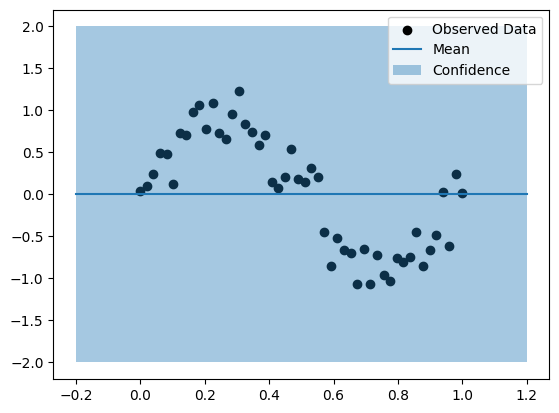

In [5]:
with torch.no_grad():
    fig, ax = plt.subplots(1, 1)

    lower, upper = y_pred.confidence_region()
    ax.scatter(train_x.numpy(), train_y.numpy(), color="black")
    ax.plot(test_x.numpy(), y_pred.mean.numpy(), color="C0")
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.4)
    ax.legend(["Observed Data", "Mean", "Confidence"])